# Binary Classification
Given a set of cat/non-cat images, try to predict if it's a cat or not

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# original_trainX : (209, 64, 64, 3)
# original_trainY : (1, 209)
# original_testX  : (50, 64, 64, 3)
# original_testY  : (1, 50)
# classes: (2,) : array([b'non-cat', b'cat'])
original_trainX, original_trainY, original_testX, original_testY, classes = load_data()

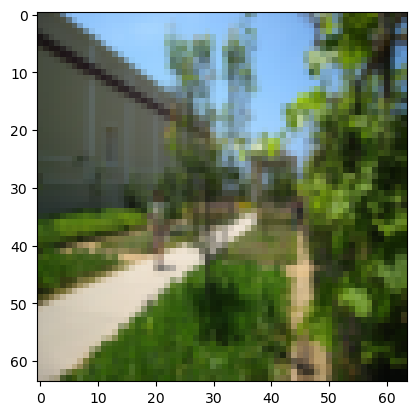

In [3]:
i = 8
plt.imshow(original_trainX[i])  # cat/non-cat dataset

In [4]:
# transpose so that x's stand vertically and are stacked sideways
trainX = original_trainX.reshape(209, -1).T  # (12288, 209)
testX = original_testX.reshape(50, -1).T  # (12288, 50)
trainX = trainX / 255.0  # normalize
testX = testX / 255.0

trainY = original_trainY
testY = original_testY

In [5]:
L = 4  # 4 layers - not including input layer ("zeroth" layer)
L_dims = [12288, 20, 7, 5, 1]

In [67]:
def init_params():
    parameters = {} # parameters "W1", "b1", ..., "WL", "bL":
                    # Wl -- weight matrix of shape (n_out, n_in)
                    # bl -- bias vector of shape (n_out, 1)
    # Xavier initialization, prevents weights from blowing up or vanishing early in training
    for l in range(1, L+1):
        n_in, n_out = L_dims[l-1], L_dims[l]
        parameters[f'W{l}'] = np.random.randn(n_out, n_in) * np.sqrt(2 / (n_in + n_out))
        parameters[f'b{l}'] = np.zeros((n_out, 1))
    return parameters
    
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache

def sigmoid(Z):
    # possible runtime error for np.exp(large number), could clip to avoid it
    Z = np.clip(Z, -500, 500)  # clip to prevent overflow
    A = 1 / (1 + np.exp(-Z))  
    cache = Z
    return A, cache 

def linear1(X, W, b) -> tuple[np.ndarray, tuple]:
    """
    Computes linear part of forward pass for 1 layer
    Args:
    * X -- inputs or activations from the previous layer (n_in, m)
    * W -- weights matrix (n_out, n_in)
    * b -- bias vector (n_out, 1)
    
    Returns:
    Z -- weighted sum or pre-activation parameter (n_out, m)
    cache -- tuple containing "X", "W" and "b", cached for computing the backward pass efficiently
    """
    Z = W @ X + b
    # Z = np.dot(W, X) + b  # should be the same
    cache = (X, W, b)
    return Z, cache
    
def forward1(X, W, b, a_t) -> tuple[np.ndarray, tuple]:
    """
    Computes forward pass for 1 layer
    Args:
    * ... -- same as linear1
    * a_t -- activation type, either "relu" or "sigmoid"

    Returns:
    A -- activation output
    cache -- tuple containing "linear_cache" and "activation_cache"
    """
    if a_t == "sigmoid":
        Z, linear_cache = linear1(X, W, b)
        A, activation_cache = sigmoid(Z)
    elif a_t == "relu":
        Z, linear_cache = linear1(X, W, b)
        A, activation_cache = relu(Z)
    else:
        raise NotImplementedError
    cache = (linear_cache, activation_cache)
    return A, cache

def forward_pass(X, parameters) -> tuple[np.ndarray, list[tuple]]:
    """
    Computes full forward pass over all layers, make sure that parameters is not empty
    Args:
    * X -- input matrix of shape (n, m)
    * parameters

    Returns:
    AL -- vector of outputs of shape (1, m)
    caches -- list of caches containing:
              every cache of forward1() with relu (there are L-1 of them, indexed from 0 to L-2)
              the cache of forward1() with sigmoid (there is one, indexed L-1)
    """
    caches = []
    A = X
    for l in range(1, L):  # loop over hidden layers
        A_prev = A
        A, cache = forward1(A_prev, parameters[f'W{l}'], parameters[f'b{l}'], 'relu')
        caches.append(cache)
    AL, cache = forward1(A, parameters[f'W{L}'], parameters[f'b{L}'], 'sigmoid')  # output layer
    caches.append(cache)

    m = X.shape[1]
    assert AL.shape == (1, m)
    return AL, caches
    
def compute_cost(AL, Y):
    """
    Cost is defined as *average* cross-entropy loss over all samples
    Args:
    * AL -- probability vector of predictions of shape (1, m)
    * Y -- ground truth vector, where each enement is either 0 or 1, shape (1, m)

    Returns:
    cost -- cross-entropy cost
    """
    m = Y.shape[1]
    eps = 1e-7
    assert (AL <= 1).all() and (AL >= 0).all()
    AL = AL.clip(eps, 1-eps)  # clip to ~[0.001, 0.999] to prevent log(0)
    cost = (-Y@np.log(AL).T - (1-Y)@np.log(1-AL).T) / m
    cost = cost.squeeze()  # equivalent to cost.reshape(())
    return cost

def relu_backward(dA, cache):
    # "dZ" = dZ / dJ = (dZ / dA) (dA / dJ) = (dZ / dA) "dA"
    Z = cache
    dZ = np.array(dA)
    dZ[Z <= 0] = 0  # derivative of relu(z) when z is negative is 0; can include 0 or not - doesn't matter
    return dZ
    
def sigmoid_backward(dA, cache):
    # "dZ" = dZ / dJ = (dZ / dA) (dA / dJ) = (dZ / dA) "dA"
    Z = cache
    Z = np.clip(Z, -500, 500) 
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)  # derivative of sigmoid: s * (1 - s)
    return dZ

def backward_linear1(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Args:
    * dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    * cache

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (dZ @ A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = W.T @ dZ
    assert dA_prev.shape == A_prev.shape
    assert dW.shape == W.shape
    assert db.shape == b.shape
    
    return dA_prev, dW, db

def backward1(dA, cache, a_t):
    """
    Implement the backward propagation for 1 layer
    
    Args:
    * dA -- post-activation gradient for current layer l 
    * ...
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if a_t == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = backward_linear1(dZ, linear_cache)
    elif a_t == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = backward_linear1(dZ, linear_cache)
    
    return dA_prev, dW, db

def backward_pass(AL, Y, caches):
    """
    Computes backward gradients for all layers
    Args:
    * AL -- probability vector
    * Y
    * caches
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    m = AL.shape[1]
    eps = 1e-7
    assert (AL <= 1).all() and (AL >= 0).all()
    AL = AL.clip(eps, 1-eps)  # clip to ~[0.001, 0.999] to prevent log(0)
    assert Y.shape == AL.shape

    dAL = -(Y / AL) + (1 - Y) / (1 - AL)  # last gradient, initializes backprop
    # dAL = -np.divide(Y, AL) + np.divide((1 - Y), (1 - AL))  # last gradient, initializes backprop
    
    cur_cache = caches[L-1]
    grads[f'dA{L}'], grads[f'dW{L}'], grads[f'db{L}'] = backward1(dAL, cur_cache, 'sigmoid')  # backward for last layer

    for l in reversed(range(L - 1)):
        cur_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = backward1(grads[f'dA{l+2}'], cur_cache, 'relu')
        grads[f'dA{l+1}'] = dA_prev_temp
        grads[f'dW{l+1}'] = dW_temp
        grads[f'db{l+1}'] = db_temp    

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    Returns:
    parameters -- updated
    """
    for l in range(1, L+1):
        parameters[f'W{l}'] = parameters[f'W{l}'] - learning_rate * grads[f'dW{l}']
        parameters[f'b{l}'] = parameters[f'b{l}'] - learning_rate * grads[f'db{l}']

    return parameters

def predict(X, Y, parameters):
    """
    Makes some predictions
    Args:
    X -- input
    Y -- ground truth
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X, shape (1, m)
    """
    m = X.shape[1]
    probs, caches = forward_pass(X, parameters)
    probs = probs.flatten()
    p = (probs > 0.5).astype(float).reshape(1, m)
    return p

In [68]:
costs = [] # retain history for plotting
train_acc = []
valid_acc = []
trained_params = {}
def model(X, Y, learning_rate=0.01, iterations=2000, testX=None, testY=None):
    costs.clear()
    train_acc.clear()
    valid_acc.clear()
    parameters = init_params()
    m = X.shape[1]
    for iteration in range(iterations):
        AL, caches = forward_pass(X, parameters)
        cost = compute_cost(AL, Y)
        costs.append(cost)
        grads = backward_pass(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        pred_train = predict(X, Y, parameters)
        tacc = np.sum(pred_train == Y) / m
        train_acc.append(tacc)
        if testX is not None and testY is not None:
            pred_test = predict(testX, testY, parameters)
            vacc = np.sum(pred_test == testY) / testX.shape[1]
            valid_acc.append(vacc)
        if iteration % 100 == 0 or iteration+1 == iterations:
            print(f'step {iteration}')
            print(f'\ttraining accuracy: {tacc:.4f}    training cost: {cost:.4f}')
            if testX is not None and testY is not None:
                print(f'\tvalidation accrcy: {vacc:.4f}')
    trained_params = parameters
        

In [69]:
from time import time
a = time()
model(trainX, trainY, 0.01, testX=testX, testY=testY)
b = time()
print(f'---\ntook {b - a :.4f} s')

step 0
	training accuracy: 0.6411    training cost: 0.8267
	validation accrcy: 0.3400
step 100
	training accuracy: 0.7895    training cost: 0.6111
	validation accrcy: 0.5800
step 200
	training accuracy: 0.7943    training cost: 0.5232
	validation accrcy: 0.7400
step 300
	training accuracy: 0.8182    training cost: 0.4460
	validation accrcy: 0.7800
step 400
	training accuracy: 0.8565    training cost: 0.3924
	validation accrcy: 0.8000
step 500
	training accuracy: 0.9330    training cost: 0.2488
	validation accrcy: 0.7800
step 600
	training accuracy: 0.9330    training cost: 0.6964
	validation accrcy: 0.6600
step 700
	training accuracy: 0.7177    training cost: 0.4891
	validation accrcy: 0.3800
step 800
	training accuracy: 0.9952    training cost: 0.0535
	validation accrcy: 0.7800
step 900
	training accuracy: 0.9952    training cost: 0.0363
	validation accrcy: 0.7800
step 1000
	training accuracy: 1.0000    training cost: 0.0263
	validation accrcy: 0.7800
step 1100
	training accuracy: 1.0

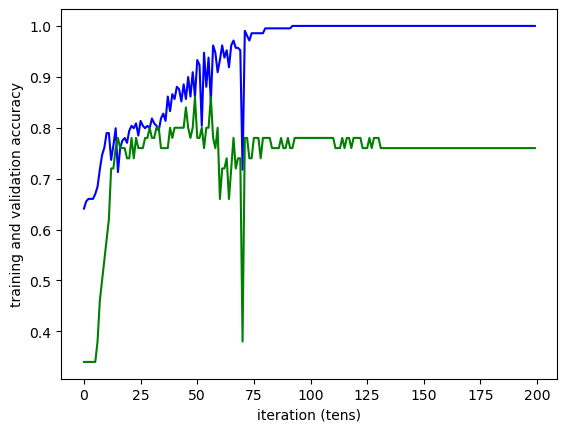

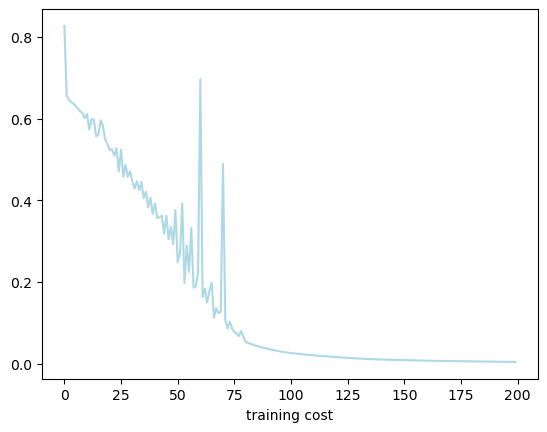

In [89]:
pcosts = [costs[i] for i in range(len(costs)) if i % 10 == 0]
ptrain_acc = [train_acc[i] for i in range(len(train_acc)) if i % 10 == 0]
pvalid_acc = [valid_acc[i] for i in range(len(valid_acc)) if i % 10 == 0]
plt.plot(ptrain_acc, color='blue')
plt.plot(pvalid_acc, color='green')
plt.xlabel('iteration (tens)')
plt.ylabel('training and validation accuracy')
plt.show()
plt.plot(pcosts, color='lightblue')
plt.xlabel('training cost')
plt.show()

# looks like there is some training instability